In [366]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
import cv2
from PIL import Image
import math
from scipy.stats import spearmanr

from baseline import MultiMethod

import torch
from torchvision import transforms
import torch.nn as nn
from muenn import MueNN
from utils import InputPadder

In [367]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [368]:
def load_data(cls):

    datas_multimodel = glob.glob(os.path.join(data_path_multimodel, cls+'*.npy'))
    datas_multitransform = glob.glob(os.path.join(data_path_multitransform, cls+'*.npy'))
    datas_truth = glob.glob(os.path.join(data_path_truth, cls+'*.npy'))
    # datas_ur = glob.glob(os.path.join(data_path_ur, 'S*.npy'))
    datas_ur_img_1 = glob.glob(os.path.join(data_path_ur, cls+'*img1.tif'))
    datas_ur_img_2 = glob.glob(os.path.join(data_path_ur, cls+'*img2.tif'))
    datas_un = glob.glob(os.path.join(data_path_un, cls+'*.npy'))

    datas_multimodel = sorted(datas_multimodel)
    datas_multitransform = sorted(datas_multitransform)
    datas_truth = sorted(datas_truth)
    datas_un = sorted(datas_un)

    # datas_ur = sorted(datas_ur)
    datas_ur_img_1 = sorted(datas_ur_img_1)
    datas_ur_img_2 = sorted(datas_ur_img_2)
    assert len(datas_multimodel) == len(datas_ur_img_1) == len(datas_ur_img_2)
    
    return datas_multimodel, datas_multitransform, datas_truth, datas_un

def compute_sigma(mms, mts, uns, mm, mt, mue):
    idx_random = random.randint(0, len(uns))
    u_res = np.abs(np.load(uns[idx_random])[-2] - np.load(uns[idx_random])[2])
    v_res = np.abs(np.load(uns[idx_random])[-1] - np.load(uns[idx_random])[3])
    u_mm, v_mm = mm.uncertainty(np.load(mms[idx_random]))
    u_mt, v_mt = mt.uncertainty(np.load(mts[idx_random]))
    data_mue = np.load(uns[idx_random])[:4]
    data_mue = torch.from_numpy(data_mue).to(DEVICE)
    u_mue, v_mue = mue.get_sigma(data_mue)
    
    mm_2d_sigma = np.sqrt(u_mm**2 + v_mm**2)
    mt_2d_sigma = np.sqrt(u_mt**2 + v_mt**2)
    mue_2d_sigma = np.sqrt(u_mue**2 + v_mue**2)
    res_2d = np.sqrt(u_res**2 + v_res**2)
    
    return np.stack((mm_2d_sigma, mt_2d_sigma, mue_2d_sigma, res_2d, np.load(mms[idx_random])[0], np.load(mms[idx_random])[1]), 0)


def get_sigma():
    
    cls = ['backstep', 'cylinder', 'JHTDB_channel', 'JHTDB_isotropic1024_hd', 'JHTDB_mhd1024_hd', 'SQG']
    model_path = '/home/panding/code/UR/unet-model/best-1.pt'
    my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mue = MueNN(model_path, my_device)
    mm = MultiMethod(0)
    mt = MultiMethod(1)
    cls_random = random.randint(0, len(cls)-1)
    print(cls[cls_random])
    mms, mts, truths, uns = load_data(cls[cls_random])
    result = compute_sigma(mms, mts, uns, mm, mt, mue)
    
    return result

In [369]:
data_path_multimodel = '/home/panding/code/UR/piv-data/unflownet-mm'
data_path_multitransform = '/home/panding/code/UR/piv-data/unflownet-mt'
data_path_truth = '/home/panding/code/UR/piv-data/truth'
data_path_un = '/home/panding/code/UR/piv-data/ur-un'
data_path_ur = '/home/panding/code/UR/piv-data/raft-test'

# data_path_multimodel = '/home/panding/code/UR/piv-data/baseline-multimodel'
# data_path_multitransform = '/home/panding/code/UR/piv-data/baseline-multitransform'
# data_path_truth = '/home/panding/code/UR/piv-data/truth'
# data_path_un = '/home/panding/code/UR/piv-data/raft-test'
# data_path_ur = '/home/panding/code/UR/piv-data/raft-test'


res = get_sigma()
print(res.shape)

JHTDB_mhd1024_hd
(6, 256, 256)


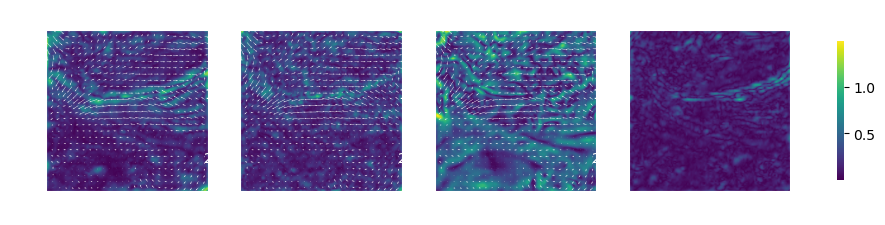

In [370]:
u = res[4]
v = res[5]

# 创建一个包含3个子图的figure
fig, axs = plt.subplots(1, 4, figsize=(12, 3), facecolor='white')

# 在每个子图中分别呈现一个通道的值
for i in range(4):
    
    x, y = np.meshgrid(np.arange(u.shape[1]), np.arange(u.shape[0]))
    arrow_interval = 10
    
    
    im = axs[i].imshow(res[i, :, :], cmap='viridis')
    if i != 3:
        axs[i].quiver(x[::arrow_interval, ::arrow_interval], y[::arrow_interval, ::arrow_interval],
            u[::arrow_interval, ::arrow_interval], v[::arrow_interval, ::arrow_interval], color='white')
        
        axs[i].set_title('Channel {}'.format(i+1))

# 设置子图背景色为白色
fig.patch.set_facecolor('white')

# 调整子图之间的间隔颜色
plt.subplots_adjust(wspace=0.2)  # 设置子图水平间距

# 创建共用的colorbar
cbar = fig.colorbar(im, ax=axs, shrink=0.6, location='right')
cbar.ax.yaxis.set_tick_params(color='black')  # 设置colorbar的字体颜色为黑色
cbar.outline.set_visible(False)  # 去除colorbar的轮廓线
cbar.ax.tick_params(colors='black')

# 展示图像
plt.show()